In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


Link to the data:
https://drive.google.com/file/d/1ITE-wx5pIenrk-c0v0ovUyu6-V1OOv26/view?usp=sharing

_(this is a subset of "skin-cancer-mnist-ham10000")_


In [2]:
df = pd.read_csv("data/HAM2000/metadata.csv")
full_name = {
    "bcc": "Basal cell carcinoma",
    "bkl": "Benign keratosis-like lesions",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
}
df["dx_full"] = df["dx"].map(full_name.get)
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_full
0,HAM_0006518,ISIC_0027618,nv,follow_up,35.0,male,back,Melanocytic nevi
1,HAM_0004666,ISIC_0029165,nv,follow_up,55.0,male,upper extremity,Melanocytic nevi
2,HAM_0006455,ISIC_0029690,nv,follow_up,50.0,male,lower extremity,Melanocytic nevi
3,HAM_0003653,ISIC_0030139,nv,histo,45.0,male,back,Melanocytic nevi
4,HAM_0001330,ISIC_0026818,nv,histo,20.0,female,abdomen,Melanocytic nevi


In [3]:
transfo = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]
)
dataset = torchvision.datasets.ImageFolder(root="data/HAM2000/", transform=transfo)
class_names = [full_name[name] for name in dataset.find_classes("data/HAM2000/")[0]]


In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)


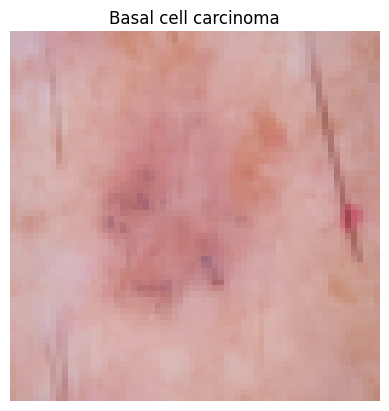

In [5]:
image, label = dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")
plt.show()


In [6]:
class SkinConvNet(nn.Module):
    def __init__(self, hidden_size=64):
        super(SkinNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, stride=2)
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1)
        self.conv4 = nn.Conv2d(32, 32, 5, stride=1)
        self.conv5 = nn.Conv2d(32, 32, 5, stride=1)
        self.fc1 = nn.Linear(14 * 14 * 32, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        # print(x.shape)
        x = x.view(-1, 14 * 14 * 32)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


In [7]:
model = SkinConvNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
losses = []
accuracies = [0.25]

In [21]:
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    correct_count = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        hot_outputs = model(images)
        outputs = hot_outputs.argmax(axis=1)
        correct_count += (outputs == labels).sum().item()
        loss = criterion(hot_outputs, labels)
        loss.backward()
        losses.append(loss.item())
        running_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    accuracy = correct_count/train_size
    accuracies.append(accuracy)
    print(f"Epoch [{epoch}/{num_epochs}] Loss: {running_loss:.6f} Accuracy: {accuracy*100:.2f}%")


Epoch [1/20] Loss: 28.366820 Accuracy: 59.13%
Epoch [2/20] Loss: 28.336368 Accuracy: 60.19%
Epoch [3/20] Loss: 28.221229 Accuracy: 60.62%
Epoch [4/20] Loss: 28.159575 Accuracy: 61.12%
Epoch [5/20] Loss: 28.335989 Accuracy: 59.81%
Epoch [6/20] Loss: 28.355695 Accuracy: 59.62%
Epoch [7/20] Loss: 28.050846 Accuracy: 61.19%
Epoch [8/20] Loss: 28.341031 Accuracy: 60.25%
Epoch [9/20] Loss: 28.435311 Accuracy: 59.62%
Epoch [10/20] Loss: 28.388683 Accuracy: 59.75%
Epoch [11/20] Loss: 27.962444 Accuracy: 61.81%
Epoch [12/20] Loss: 27.977969 Accuracy: 61.75%
Epoch [13/20] Loss: 28.003917 Accuracy: 61.88%
Epoch [14/20] Loss: 28.182124 Accuracy: 61.25%
Epoch [15/20] Loss: 28.286723 Accuracy: 60.88%
Epoch [16/20] Loss: 28.077125 Accuracy: 61.94%
Epoch [17/20] Loss: 28.048645 Accuracy: 61.56%
Epoch [18/20] Loss: 28.215048 Accuracy: 60.25%
Epoch [19/20] Loss: 28.541422 Accuracy: 59.19%
Epoch [20/20] Loss: 27.976277 Accuracy: 62.00%


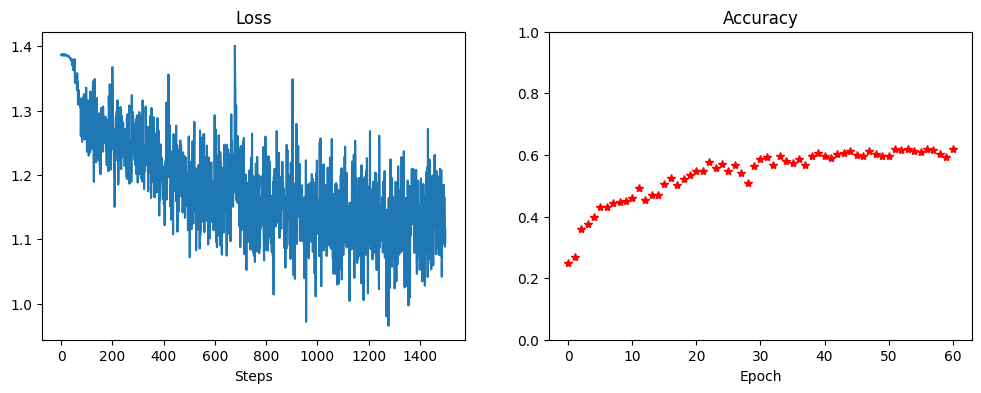

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Steps")
plt.subplot(1,2,2)
plt.plot(accuracies, '*r')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()


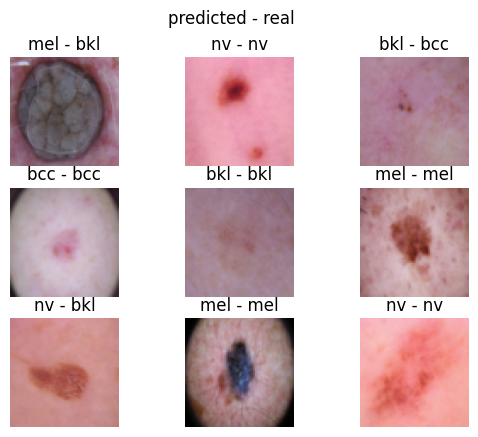

In [23]:
small_class_names = dataset.find_classes("data/HAM2000/")[0]
for images, labels in test_loader:
    predictions = model(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].numpy().swapaxes(0, 2).swapaxes(0, 1))
        pred_class = small_class_names[torch.argmax(predictions[i])]
        real_class = small_class_names[labels[i]]
        ax.set_title(f"{pred_class} - {real_class}")
        plt.axis("off")
    plt.suptitle("predicted - real")
    plt.show()
    break


In [24]:
correct = 0
total = 0
for images, labels in test_loader:
    predictions = model(images)
    total += labels.size(0)
    correct += (torch.argmax(predictions, dim=1) == labels).sum().item()

print(f"Accuracy: {100*correct/total:.2f} %")


Accuracy: 59.00 %
